In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import requests
from statistics import mean

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

# import package
import pandas_datareader.data as web
## set start and end dates 
# start = datetime.datetime(2016, 9, 5) 
start = datetime.datetime(2011, 5, 5) 
end = datetime.datetime(2021, 4, 22) 

symbol = 'AAPL'

# extract the closing price data
tsla_df = web.DataReader(['TSLA'], 'yahoo', start = start, end = end)
df = web.DataReader([symbol], 'yahoo', start = start, end = end)
btc_df = web.DataReader(['BTC-USD'], 'yahoo', start = start, end = end)

daily_df_original = df #tsla_df bitcoin_df
weekly_df_original = web.get_data_yahoo(symbol, start = start, end = end ,interval='w')
monthly_df_original = web.get_data_yahoo(symbol, start = start, end = end ,interval='m')

stock_close = daily_df_original['Adj Close']
stock_close.columns = {'Close Price'}
daily_df_original.head(10) #daily_df_original

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2011-05-05,10.667065,12.383929,12.533929,12.358929,12.442857,335969200.0
2011-05-06,10.664294,12.380714,12.500000,12.364643,12.488929,280134400.0
2011-05-09,10.693214,12.414286,12.471429,12.376071,12.423571,204747200.0
2011-05-10,10.750122,12.480357,12.488929,12.380714,12.460357,282091600.0
2011-05-11,10.681831,12.401071,12.500000,12.330000,12.465000,336000000.0
2011-05-12,10.661525,12.377500,12.397143,12.223929,12.361429,322000000.0
2011-05-13,10.474795,12.160714,12.366071,12.155357,12.345000,326116000.0
2011-05-16,10.253304,11.903571,12.186429,11.878571,12.114286,449775200.0


In [2]:
monthly_df_original.tail(5) #aapl_df_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-01,138.789993,120.010002,121.010002,132.690002,2.322957e+09,132.492020
2021-01-01,145.089996,126.379997,133.520004,131.960007,2.240534e+09,131.763107
2021-02-01,137.880005,118.389999,133.750000,121.260002,1.833204e+09,121.079071
2021-03-01,128.720001,116.209999,123.750000,122.150002,2.645228e+09,122.150002
2021-04-01,135.529999,122.489998,123.660004,134.320007,1.387828e+09,134.320007


In [3]:
#### Original data gets manipulated the same was as the copied data here...
# stock_df = daily_df_original
##
# stock_df.drop('Adj Close', inplace=True, axis=1, level=0)
# stock_df.drop('Close', inplace=True, axis=1, level=0)
# stock_df.drop('High', inplace=True, axis=1, level=0)
# stock_df.drop('Low', inplace=True, axis=1, level=0)
# stock_df.drop('Open', inplace=True, axis=1, level=0)
##
# del stock_df['Adj Close']
# del stock_df['Close']
# del stock_df['High']
# del stock_df['Low']
# del stock_df['Open']

## Explicit copied framework of the orignal dataframe, so to only include the same index dates
stock_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)


stock_df.tail(5) 

""
Date
2021-04-16
2021-04-19
2021-04-20
2021-04-21
2021-04-22


<AxesSubplot:title={'center':'Adjusted Closing Price'}, xlabel='Date'>

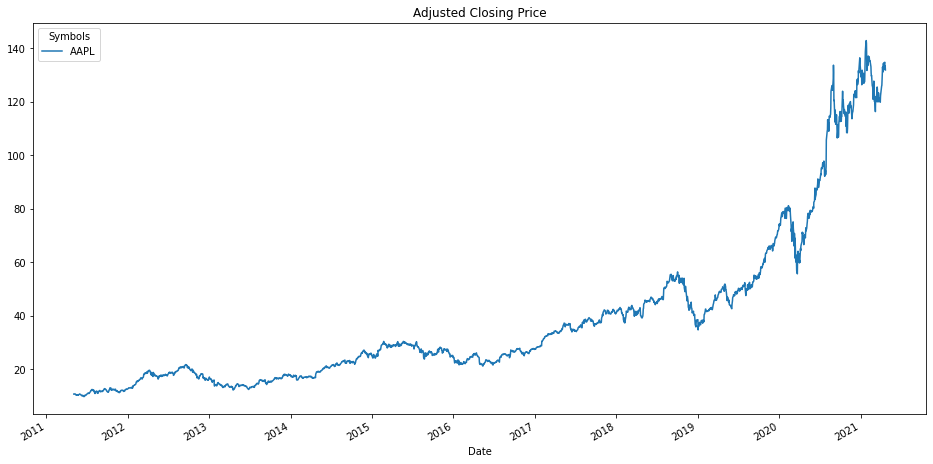

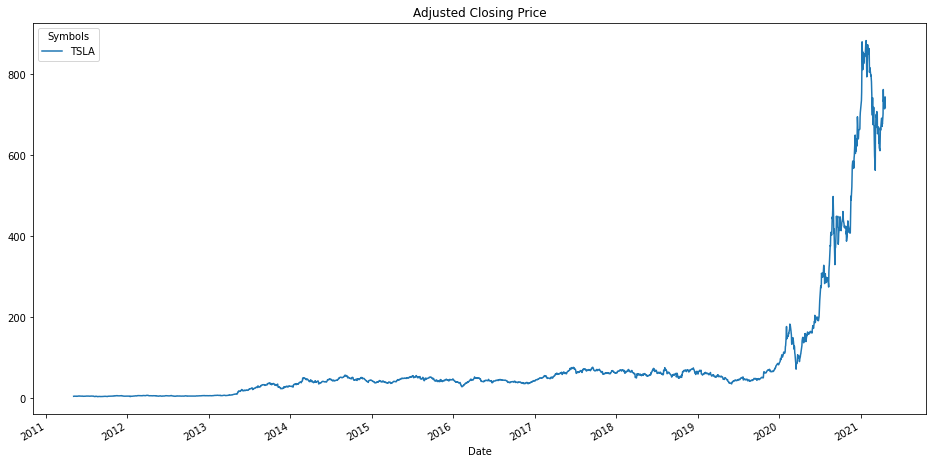

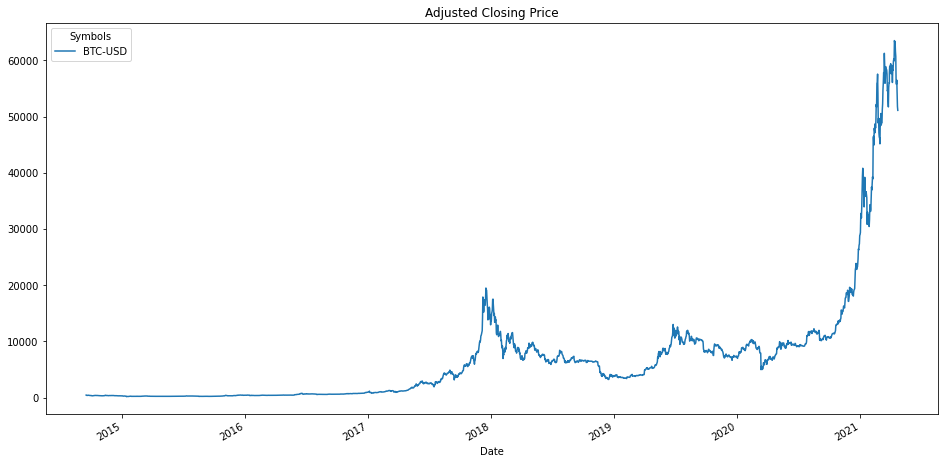

In [4]:
df['Adj Close'].plot(label='Apple',figsize = (16,8),title="Adjusted Closing Price")
tsla_df['Adj Close'].plot(label='Tesla',figsize = (16,8),title="Adjusted Closing Price")
btc_df['Adj Close'].plot(label='Bitcoin',figsize = (16,8),title="Adjusted Closing Price")


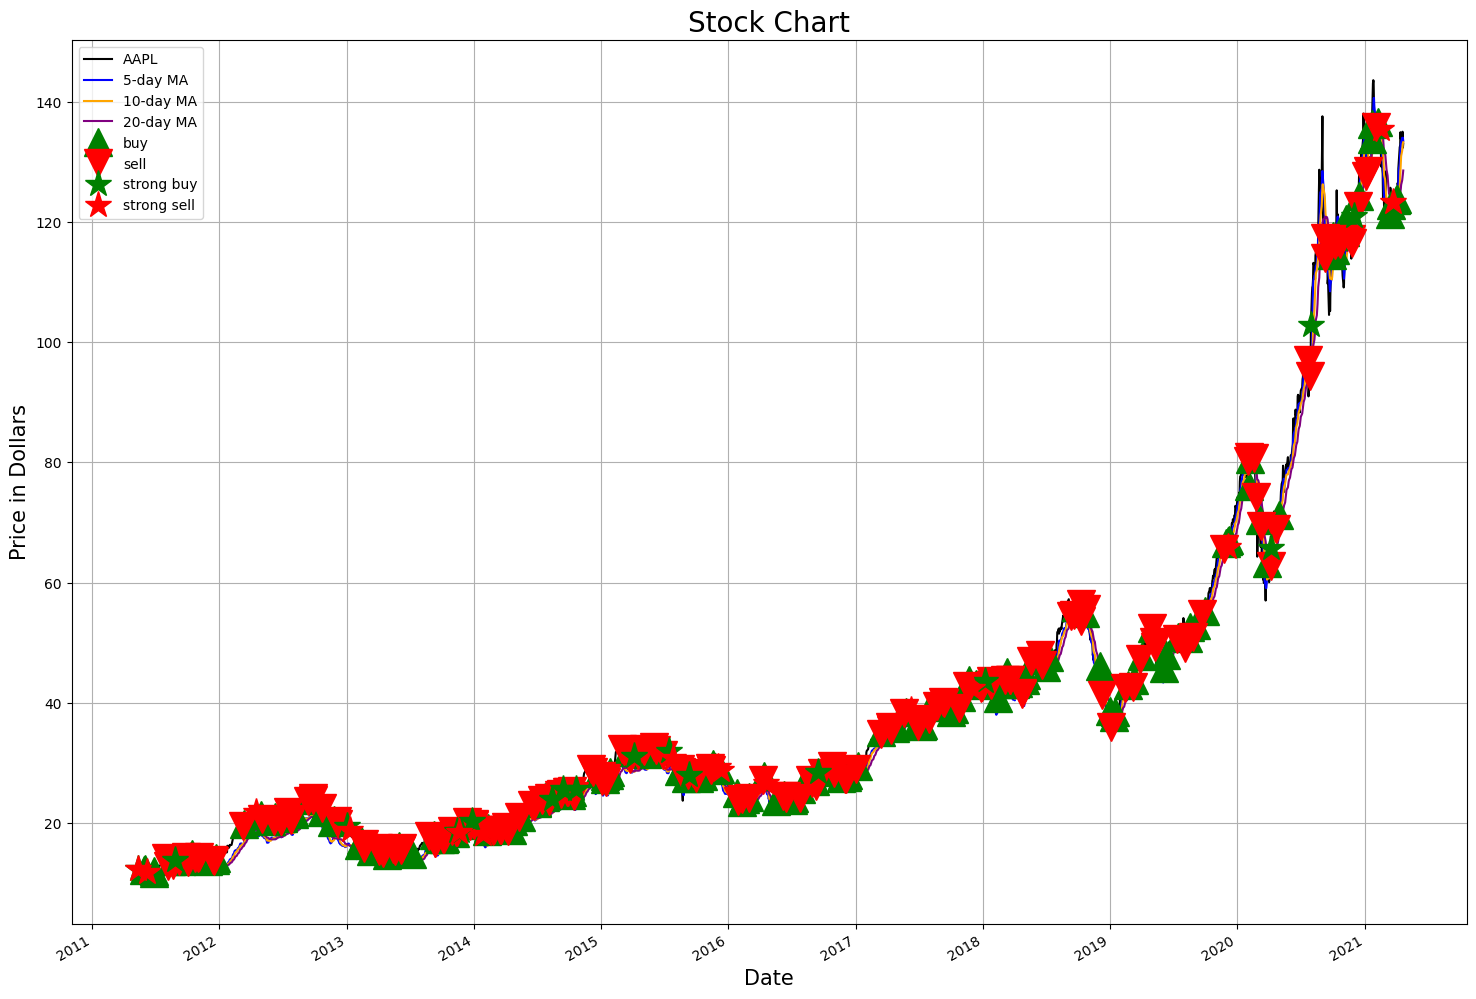

In [5]:
# create 5 days simple moving average column
#stock_MAs = pd.DataFrame()
stock_MAs = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)
stock_MAs['5MA'] = stock_close['Close Price'].rolling(window = 5, min_periods = 1).mean()
# create 10 days simple moving average column
stock_MAs['10MA'] = stock_close['Close Price'].rolling(window = 10, min_periods = 1).mean()
# create 20 days simple moving average column
stock_MAs['20MA'] = stock_close['Close Price'].rolling(window = 20, min_periods = 1).mean()

## When the short term 5-day-moving average crosses above the long term 20-day-
## moving average, this indicates a buy signal "1.0". 
##
## Sell signal is the opposite represented by "0.0".

## 5-MA crossing the 20-MA
stock_df['10MA_Signal'] = 0.0
stock_df['10MA_Signal'] = np.where(stock_MAs['5MA'] > stock_MAs['10MA'], 1.0, 0.0)

## 10-MA crossing the 20-MA
stock_df['20MA_Signal'] = 0.0
stock_df['20MA_Signal'] = np.where(stock_MAs['5MA'] > stock_MAs['20MA'], 1.0, 0.0)


## When ‘XMA_Signal_Change’ = 1, it implies that the XMA_Cross Signal has changed from 0 to 1
## meaning a short-term(faster) moving average has crossed above the
## long-term(slower) moving average, thereby triggering a buy call.
## 
## When ‘XMA_Signal_Change’ = -1, it implies that the XMA_Cross Signal has changed from 1 to 0
## meaning a short-term(faster) moving average has crossed below the
## long-term(slower) moving average, thereby triggering a sell call.
MA10_signal = stock_df['10MA_Signal'].diff()
stock_df['10MA_Signal_Change'] = MA10_signal

MA20_signal = stock_df['20MA_Signal'].diff()
stock_df['20MA_Signal_Change'] = MA20_signal

## 1 means both the 5MA and 10MA have buy signals, whereas -1 means both the 5MA and 10MA have sell signals.
## 0 registers as conclicting opinion between the moving averages.
stock_df['MA_Signal_Change'] = ( MA10_signal + MA20_signal )
#stock_df = stock_df.set_index(daily_df_original.index)

#daily_df_original['MA_Signal_Change'] = ( MA10_signal + MA20_signal )


#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_MAs['5MA'].plot(color = 'b',label = '5-day MA') 
stock_MAs['10MA'].plot(color = 'orange', label = '10-day MA')
stock_MAs['20MA'].plot(color = 'purple', label = '20-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()


In [6]:
#### Distance & Rate of Change between the low & high daily stock prices and its 5-day moving average.
stock_df['Distance_of_Low_to_5MA'] = daily_df_original['Low'].subtract(stock_MAs['5MA'], axis='index')
Low_5MA = stock_df['Distance_of_Low_to_5MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_5MA
stock_df['Distance_of_High_to_5MA'] = daily_df_original['High'].subtract(stock_MAs['5MA'], axis='index')
High_5MA = stock_df['Distance_of_Low_to_5MA'].diff()
stock_df['ROC_of_High_to_5MA'] = High_5MA

## Distance & Rate of Change between the low & high daily stock prices and its 10-day moving average.
stock_df['Distance_of_Low_to_10MA'] = daily_df_original['Low'].subtract(stock_MAs['10MA'], axis='index')
Low_10MA = stock_df['Distance_of_Low_to_10MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_10MA
stock_df['Distance_of_High_to_10MA'] = daily_df_original['High'].subtract(stock_MAs['10MA'], axis='index')
High_10MA = stock_df['Distance_of_Low_to_10MA'].diff()
stock_df['ROC_of_High_to_10MA'] = High_10MA

## Distance & Rate of Change between the low & high daily stock prices and its 20-day moving average.
stock_df['Distance_of_Low_to_20MA'] = daily_df_original['Low'].subtract(stock_MAs['20MA'], axis='index')
Low_20MA = stock_df['Distance_of_Low_to_20MA'].diff()
stock_df['ROC_of_Low_to_5MA'] = Low_20MA
stock_df['Distance_of_High_to_20MA'] = daily_df_original['High'].subtract(stock_MAs['20MA'], axis='index')
High_20MA = stock_df['Distance_of_Low_to_20MA'].diff()
stock_df['ROC_of_High_to_10MA'] = High_20MA



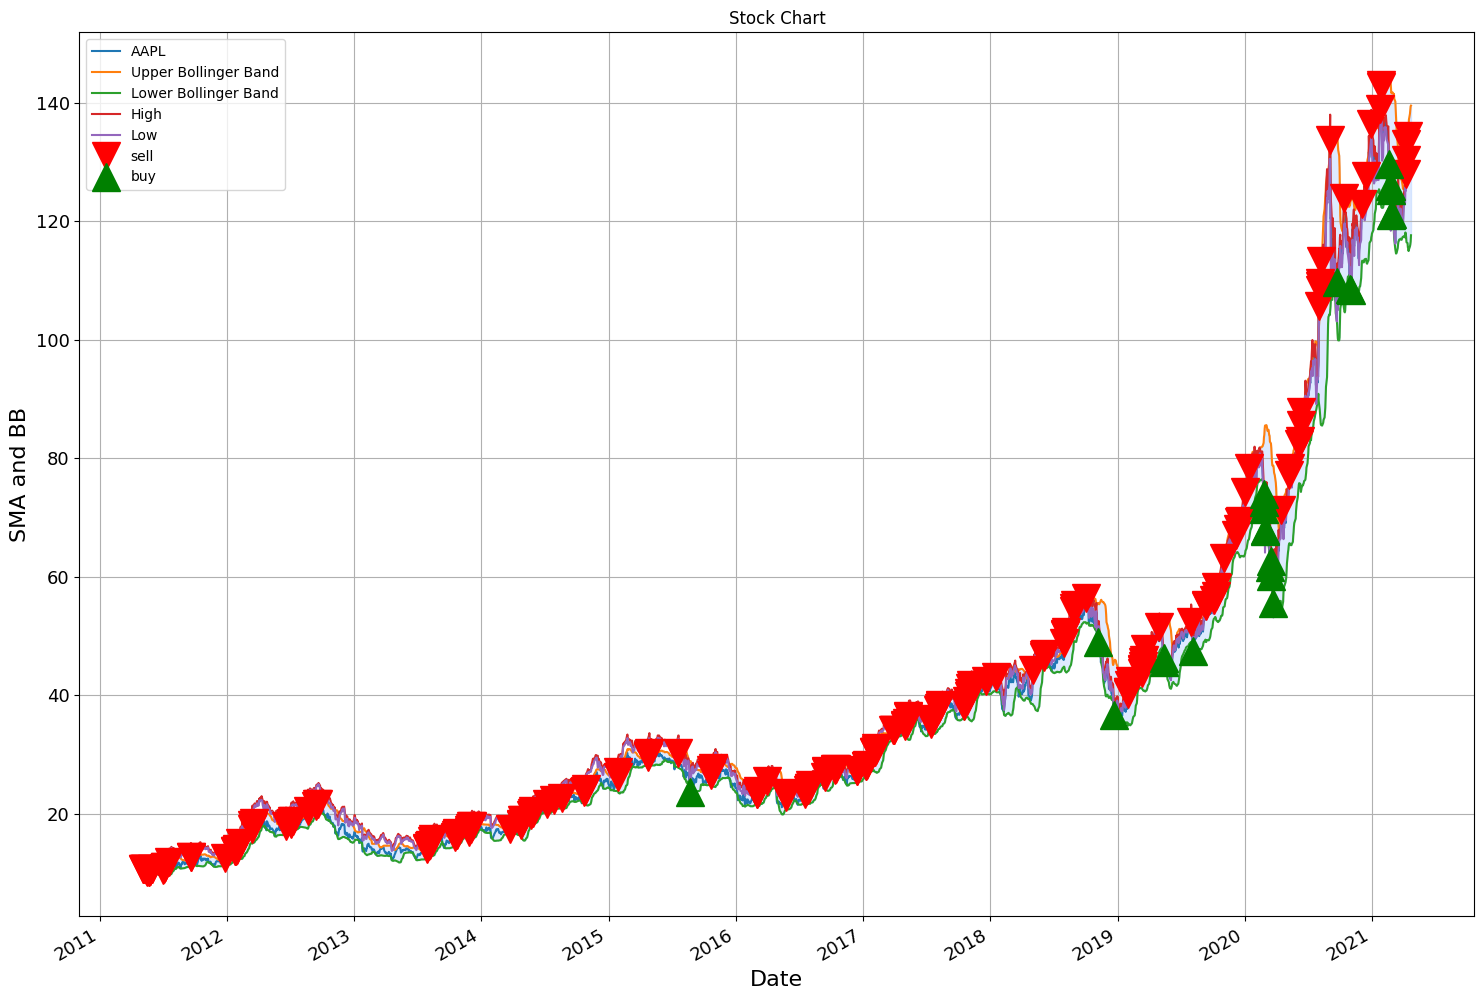

In [7]:
## Bollinger Bands


symbol='AAPL'
# # read csv file, use date as index and read close as a column
# df = pd.read_csv('~/workspace/{}.csv'.format(symbol), index_col='date',
#                  parse_dates=True, usecols=['date', 'close'],
#                  na_values='nan')


# rename the column header with symbol name
bollinger_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)
bollinger_df = stock_close.rename(columns={'Close Price': symbol})
bollinger_df.dropna(inplace=True)

# calculate Simple Moving Average with 20 days window
MA20 = bollinger_df.rolling(window=20).mean()

# calculate the standar deviation
STD_DEV = bollinger_df.rolling(window=20).std()

upper_band = MA20 + 2 * STD_DEV
upper_band = upper_band.rename(columns={symbol: 'Upper Bollinger Band'})
lower_band = MA20 - 2 * STD_DEV
lower_band = lower_band.rename(columns={symbol: 'Lower Bollinger Band'})


#high = daily_df_original['High'].rename(columns={symbol: 'High'})


bollinger_df = bollinger_df.join(upper_band).join(lower_band)
bollinger_df['High'] = daily_df_original['High']
bollinger_df['Low'] = daily_df_original['Low']

ax = bollinger_df.plot(title='Stock Chart'.format(symbol),fontsize = 13)
#ax = bollinger_df.plot(title='{} Price and BB'.format(symbol),fontsize = 13)
ax.fill_between(bollinger_df.index, lower_band['Lower Bollinger Band'], upper_band['Upper Bollinger Band'], color='#ADCCFF', alpha=0.4)



## Add the BOLL Signal to the main indicator dataframe

# ##For Upper_BOLL_Signal, a buy signal is represented by 1.0 when the closing daily price hits at/over the high bollinger band.
# High_BOLL = 0
# if bollinger_df.iloc[0][symbol] >= bollinger_df.iloc[0]['Upper Bollinger Band']:
#     High_BOLL = 1.0
# else:
#     High_BOLL = 0.0
# stock_df['High_BOLL_Signal'] = High_BOLL

bollinger_df = bollinger_df.fillna(0)


high_BOLL_labels = []
low_BOLL_labels = []
for price_index in range(len(stock_df)):
    
    if (bollinger_df.iloc[price_index]['Upper Bollinger Band'] == 0) & (bollinger_df.iloc[price_index]['Lower Bollinger Band'] == 0):
        high_BOLL_labels.append(0.0)
        low_BOLL_labels.append(0.0)
    
    ## For Upper_BOLL_Signal, a buy signal is represented by 1.0 when the closing daily price hits at/over the high bollinger band.
    elif bollinger_df.iloc[price_index][symbol] >= bollinger_df.iloc[price_index]['Upper Bollinger Band']: #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
        high_BOLL_labels.append(1.0)
        low_BOLL_labels.append(0.0)
    
    ## For Lower_BOLL_Signal, a sell signal is represented by 1.0 when the lowest daily price hits at/below the low bollinger band.
    elif bollinger_df.iloc[price_index][symbol] <= bollinger_df.iloc[price_index]['Lower Bollinger Band']: # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
        low_BOLL_labels.append(1.0)   
        high_BOLL_labels.append(0.0)

    else:
        high_BOLL_labels.append(0.0)
        low_BOLL_labels.append(0.0)
        
        
stock_df['High_BOLL_Signal'] = high_BOLL_labels    
stock_df['Low_BOLL_Signal'] = low_BOLL_labels


# ## For Lower_BOLL_Signal, a sell signal is represented by 1.0 when the lowest daily price hits at/below the low bollinger band.
# #stock_df['Low_BOLL_Signal'] = np.where(daily_df_original['Low'] <= bollinger_df['Lower Bollinger Band'], 1.0, 0.0)
# Low_BOLL = 0
# if bollinger_df.iloc[0][symbol] <= bollinger_df.iloc[0]['Lower Bollinger Band']:
#     Low_BOLL = 1.0
# else:
#     Low_BOLL = 0.0
# stock_df['Low_BOLL_Signal'] = Low_BOLL
# #stock_df['High_BOLL_Signal'] = lower_band


#### Distance between the low, High, and Close daily stock prices and its Low and High Bollinger bands.
stock_df['Distance_of_High_to_High_BOLL'] = daily_df_original['High'].subtract(bollinger_df['Upper Bollinger Band'], axis='index')
High_Price_High_BOLL = stock_df['Distance_of_High_to_High_BOLL'].diff()
stock_df['ROC_of_High_to_High_BOLL'] = High_Price_High_BOLL
stock_df['Distance_of_Close_to_High_BOLL'] = daily_df_original['Adj Close'].subtract(bollinger_df['Upper Bollinger Band'], axis='index')
Close_Price_High_BOLL = stock_df['Distance_of_Close_to_High_BOLL'].diff()
stock_df['ROC_of_Close_to_High_BOLL'] = Close_Price_High_BOLL

stock_df['Distance_of_Low_to_Low_BOLL'] = daily_df_original['Low'].subtract(bollinger_df['Lower Bollinger Band'], axis='index')
Low_Price_Low_BOLL = stock_df['Distance_of_Low_to_Low_BOLL'].diff()
stock_df['ROC_of_Low_to_Low_BOLL'] = Low_Price_Low_BOLL
stock_df['Distance_of_Close_to_Low_BOLL'] = daily_df_original['Adj Close'].subtract(bollinger_df['Lower Bollinger Band'], axis='index')
Close_Price_Low_BOLL = stock_df['Distance_of_Close_to_Low_BOLL'].diff()
stock_df['ROC_of_Close_to_Low_BOLL'] = Close_Price_Low_BOLL



## Graphing

# plot ‘sell’ signals
plt.plot(bollinger_df[bollinger_df[symbol] >= bollinger_df['Upper Bollinger Band']].index, 
         bollinger_df[symbol][bollinger_df[symbol] >= bollinger_df['Upper Bollinger Band']], 
         'v', markersize = 20, color = 'r', label = 'sell')

# # plot ‘buy’ signals
plt.plot(bollinger_df[bollinger_df['Low'] <= bollinger_df['Lower Bollinger Band']].index, 
         bollinger_df[symbol][bollinger_df['Low'] <= bollinger_df['Lower Bollinger Band']], 
         '^', markersize = 20, color = 'g', label = 'buy')

# # plot ‘strong buy’ signals
# plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] >= 2].index, 
#          daily_df_original['Open'][stock_df['EMA_Signal_Change'] >= 2], 
#          '*', markersize = 20, color = 'g', label = 'strong buy')
# # plot ‘strong sell’ signals
# plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -2].index, 
#          daily_df_original['Open'][stock_df['EMA_Signal_Change'] <= -2], 
#          '*', markersize = 20, color = 'r', label = 'strong sell')


ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('SMA and BB',fontsize = 16)
plt.legend()
ax.grid()
#plt.show()



# # Calculating the standar deviation
# STD_DEV = daily_df_original['Close'].rolling(window=20).std()

# # Calling the 20-day simple moving average
# MA20 = stock_MAs['20MA']

# upper_band = MA20 + 2 * STD_DEV
# stock_df['Upper Bollinger'] = upper_band
# #upper_band = upper_band.rename(columns={symbol: 'upper'})
# lower_band = MA20 - 2 * STD_DEV
# stock_df['Lower Bollinger'] = lower_band
# #lower_band = lower_band.rename(columns={symbol: 'lower'})

# #stock_df = stock_df[upper_band).join(lower_band)
# #ax = df.plot(title='{} Price and BB'.format(symbol))
# ax = daily_df_original.plot(title='Price and BB')
# ax.fill_between(stock_df.index, lower_band, upper_band, color='#ADCCFF', alpha='0.4')
# ax.set_xlabel('Date')
# ax.set_ylabel('SMA and BB')
# ax.grid()
# plt.show()

In [8]:
bollinger_df[50:]

,AAPL,Upper Bollinger Band,Lower Bollinger Band,High,Low
Date,,,,,
2011-07-18,11.499201,11.573790,9.595571,13.380357,13.045714
2011-07-19,11.593031,11.674299,9.684347,13.523214,13.332857
2011-07-20,11.902196,11.856614,9.691531,14.152500,13.785714
2011-07-21,11.914196,11.992447,9.754674,13.930714,13.710714
2011-07-22,12.099082,12.165378,9.772689,14.108929,13.848214
...,...,...,...,...,...
2021-04-16,134.160004,137.143159,115.254840,134.669998,133.279999
2021-04-19,134.839996,138.124367,115.758633,135.470001,133.339996
2021-04-20,133.110001,138.803669,116.051331,135.529999,131.809998


In [9]:
bollinger_df.tail(5)

,AAPL,Upper Bollinger Band,Lower Bollinger Band,High,Low
Date,,,,,
2021-04-16,134.160004,137.143159,115.254840,134.669998,133.279999
2021-04-19,134.839996,138.124367,115.758633,135.470001,133.339996
2021-04-20,133.110001,138.803669,116.051331,135.529999,131.809998
2021-04-21,133.500000,139.416086,116.534913,133.750000,131.300003
2021-04-22,131.940002,139.505413,117.630587,134.149994,131.410004


In [10]:
daily_df_original.tail(10)

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2021-04-09,133.000000,133.000000,133.039993,129.470001,129.800003,106513800.0
2021-04-12,131.240005,131.240005,132.850006,130.630005,132.520004,91420000.0
2021-04-13,134.429993,134.429993,134.660004,131.929993,132.440002,91266500.0
2021-04-14,132.029999,132.029999,135.000000,131.660004,134.940002,87222800.0
2021-04-15,134.500000,134.500000,135.000000,133.639999,133.820007,89347100.0
2021-04-16,134.160004,134.160004,134.669998,133.279999,134.300003,84818500.0
2021-04-19,134.839996,134.839996,135.470001,133.339996,133.509995,94264200.0
2021-04-20,133.110001,133.110001,135.529999,131.809998,135.020004,94812300.0


In [11]:
stock_df.tail(10)

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,High_BOLL_Signal,Low_BOLL_Signal,Distance_of_High_to_High_BOLL,ROC_of_High_to_High_BOLL,Distance_of_Close_to_High_BOLL,ROC_of_Close_to_High_BOLL,Distance_of_Low_to_Low_BOLL,ROC_of_Low_to_Low_BOLL,Distance_of_Close_to_Low_BOLL,ROC_of_Close_to_Low_BOLL
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-09,1.0,1.0,0.0,0.0,0.0,0.796001,0.397997,4.365993,-1.050003,4.368001,...,1.0,0.0,2.135312,0.638762,2.095319,0.628767,13.024683,1.857229,16.554682,3.547231
2021-04-12,1.0,1.0,0.0,0.0,0.0,0.888004,0.649503,3.108005,0.092003,4.525004,...,0.0,0.0,0.806618,-1.328695,-0.803383,-2.898702,14.302394,1.277711,14.912394,-1.642288
2021-04-13,1.0,1.0,0.0,0.0,0.0,0.543993,0.777988,3.274004,-0.344011,4.520992,...,1.0,0.0,0.859335,0.052717,0.629324,1.432707,16.315662,2.013269,18.815662,3.903268
2021-04-14,1.0,1.0,0.0,0.0,0.0,-0.551996,-0.592989,2.788000,-1.095988,3.038004,...,0.0,0.0,0.306269,-0.553066,-2.663732,-3.293056,16.292736,-0.022927,16.662731,-2.152932
2021-04-15,1.0,1.0,0.0,0.0,0.0,0.600000,1.492996,1.960001,1.151996,3.782999,...,0.0,0.0,-1.064643,-1.370912,-1.564643,1.099090,18.669643,2.376908,19.529644,2.866913
2021-04-16,1.0,1.0,0.0,0.0,0.0,0.007999,-1.041501,1.397998,-0.592001,2.306998,...,0.0,0.0,-2.473161,-1.408518,-2.983155,-1.418513,18.025158,-0.644485,18.905163,-0.624481
2021-04-19,1.0,1.0,0.0,0.0,0.0,-0.652002,-0.682502,1.478003,-0.660001,1.472997,...,0.0,0.0,-2.654366,-0.181205,-3.284370,-0.301215,17.581364,-0.443795,19.081364,0.176201
2021-04-20,1.0,1.0,0.0,0.0,0.0,-1.918002,-2.015999,1.801999,-1.266000,-0.747002,...,0.0,0.0,-3.273670,-0.619304,-5.693668,-2.409298,15.758667,-1.822697,17.058670,-2.022694
2021-04-21,1.0,1.0,0.0,0.0,0.0,-2.721997,-1.057994,-0.272000,-0.803995,-1.816997,...,0.0,0.0,-5.666086,-2.392416,-5.916086,-0.222418,14.765090,-0.993577,16.965087,-0.093583


In [12]:
#     Compare_Stocks = pd.DataFrame(columns=["Company", "Days_Observed", "Crosses", "True_Positive", "False_Positive", "True_Negative", "False_Negative", "Sensitivity","Specificity", "Accuracy", "TPR", "FPR"]) 
#     count =0
#     #stocks = [aapl_df,tsla_df,bitcoin_df]
#     stock_names = [("Apple",aapl_df),("Tesla",tsla_df),("Bitcoin",btc_df)]
#     for index_stock,stock in enumerate(stock_names):
#         # Constants for the stock that we will be updating later
#         Company = stock_names[index_stock][0]
#         stock_df = stock_names[index_stock][1]
Days_Observed = 0
Crosses = 0
#         True_Positive = 0
#         False_Positive = 0
#         True_Negative = 0
#         False_Negative = 0
#         Sensitivity = 0
#         Specificity = 0
#         Accuracy = 0
# This list holds the closing prices of a stock
prices = []
c = 0
# Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
while c < len(daily_df_original):
    if daily_df_original.iloc[c,4] > float(2.00):  # Check that the closing price for this day is greater than $2.00
        prices.append(daily_df_original.iloc[c,1])
    c += 1
prices_df = pd.DataFrame(data=prices, columns=None, index=daily_df_original.index)
#prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list

# Calculate exponentiall weighted moving averages:
EMA12 = daily_df_original.ewm(span=12).mean()
EMA26 = daily_df_original.ewm(span=26).mean()
MACD = []  # List to hold the MACD line values
counter=0  # Loop to substantiate the MACD line
while counter < (len(EMA12)):
    MACD.append(EMA12.iloc[counter,0] - EMA26.iloc[counter,0])  # Subtract the 26 day EMA from the 12 day.
    counter += 1
    
MACD_df = pd.DataFrame(data=MACD, columns=None, index=daily_df_original.index)
#MACD_df = pd.DataFrame(MACD)
#MACD_df["MACD"]z
EMA9_on_MACD_df = MACD_df.ewm(span=9).mean() # Create the signal line, which is a 9 day EMA for signal smoothing
EMA9_MACD = EMA9_on_MACD_df.values.tolist()  # Add the signal line values to a list.
#  Loop to Compare the expected MACD crosses results to the actual results
Day = 1
while Day < len(MACD)-5: # -1 to be able to use the last day for prediction, -5 so we can look at the 5 day post average.
    Prev_Day = Day-1
    # Avg_Closing_Next_Days = (prices[Day+1] + prices[Day+2] + prices[Day+3] + prices[Day+4] + prices[Day+5])/5 # To use 5 day average as a decision.
    Avg_Closing_Next_Days = (prices[Day+1] + prices[Day+2] + prices[Day+3])/3  # To use 3 day average as a decision.
    Days_Observed += 1  # Count how many days were observed
    
    
    if ((EMA9_MACD[Prev_Day] > MACD[Prev_Day]) and (EMA9_MACD[Day] <= MACD[Day])):  # when the signal line dips below the MACD line (Expected increase over the next x days)
        Crosses += 1   # register that a cross occurred

        ## 12-EMA crossing the 26-EMA
        stock_df['MACD_Signal'] = 1.0
        MACD_change = stock_df['MACD_Signal'].diff()
        stock_df['MACD_Signal_Change'] = MACD_change
        
        #stock_df['MACD_Cross'] = np.where(stock_df['5_MA'] > stock_df['20_MA'], 1.0, 0.0)

#                 if (prices[Day] < Avg_Closing_Next_Days):  # Tests if the price increases over the next x days.
#                     True_Positive += 1
#                 else:
#                     False_Negative += 1

    if ((EMA9_MACD[Prev_Day] < MACD[Prev_Day]) and (EMA9_MACD[Day] >= MACD[Day])): # when the signal line moves above the MACD line (Expected dip over the next x days)
        Crosses += 1

        ## 26-EMA crossing the 12-EMA
        stock_df['MACD_Signal'] = -1.0
        MACD_change = stock_df['MACD_Signal'].diff()
        stock_df['MACD_Signal_Change'] = MACD_change

#                 if (prices[Day] > Avg_Closing_Next_Days):  # Tests if the price decreases over the next x days.
#                     True_Negative += 1
#                 else:
#                     False_Positive += 1
    Day += 1
    
    ## Measure the distance and rate of change between indicators.
    stock_df['Distance_of_Close_to_Future_MACD'] = daily_df_original['Adj Close'].subtract(Avg_Closing_Next_Days, axis='index')
    Close_MACD = stock_df['Distance_of_Close_to_Future_MACD'].diff()
    stock_df['ROC_of_Close_to_Future_MACD'] = Close_MACD
    
    stock_df['Distance_of_EMA9_to_MACD'] = EMA9_on_MACD_df.subtract(MACD[Day], axis='index') #daily_df_original['Adj Close'].subtract(Avg_Closing_Next_Days, axis='index')
    EMA9_MACD = stock_df['Distance_of_EMA9_to_MACD'].diff()
    stock_df['ROC_of_EMA9_to_MACD'] = EMA9_MACD


#         try:
#             Sensitivity = (True_Positive / (True_Positive + False_Negative)) # Calculate sensitivity
#         except ZeroDivisionError:  # Catch the divide by zero error
#             Sensitivity = 0
#         try:
#             Specificity = (True_Negative / (True_Negative + False_Positive)) # Calculate specificity
#         except ZeroDivisionError:
#             Specificity
#         try:
#             Accuracy = (True_Positive + True_Negative) / (True_Negative + True_Positive + False_Positive + False_Negative) # Calculate accuracy
#         except ZeroDivisionError:
#             Accuracy = 0
#         TPR = Sensitivity  # Calculate the true positive rate
#         FPR = 1 - Specificity  # Calculate the false positive rate

        # Create a row to add to the compare_stocks
#         add_row = {'Company' : Company, 'Days_Observed' : Days_Observed, 'Crosses' : Crosses, 'True_Positive' : True_Positive, 'False_Positive' : False_Positive, 
#         'True_Negative' : True_Negative, 'False_Negative' : False_Negative, 'Sensitivity' : Sensitivity, 'Specificity' : Specificity, 'Accuracy' : Accuracy, 'TPR' : TPR, 'FPR' : FPR}
#         Compare_Stocks = Compare_Stocks.append(add_row, ignore_index = True) # Add the analysis on the stock to the existing Compare_Stocks dataframe
#         count += 1
#     Compare_Stocks.to_csv("All_Stocks.csv", index = False)  # Save the compiled data on each stock to a csv - All_Stocks.csv

In [13]:
stock_df.tail(10)

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_Low_to_Low_BOLL,ROC_of_Low_to_Low_BOLL,Distance_of_Close_to_Low_BOLL,ROC_of_Close_to_Low_BOLL,Distance_of_Close_to_Future_MACD,ROC_of_Close_to_Future_MACD,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-09,1.0,1.0,0.0,0.0,0.0,0.796001,0.397997,4.365993,-1.050003,4.368001,...,13.024683,1.857229,16.554682,3.547231,-1.036667,2.639999,-3.004725,0.371445,1.0,0.0
2021-04-12,1.0,1.0,0.0,0.0,0.0,0.888004,0.649503,3.108005,0.092003,4.525004,...,14.302394,1.277711,14.912394,-1.642288,-2.796661,-1.759995,-2.640619,0.364106,1.0,0.0
2021-04-13,1.0,1.0,0.0,0.0,0.0,0.543993,0.777988,3.274004,-0.344011,4.520992,...,16.315662,2.013269,18.815662,3.903268,0.393326,3.189987,-2.249203,0.391416,1.0,0.0
2021-04-14,1.0,1.0,0.0,0.0,0.0,-0.551996,-0.592989,2.788000,-1.095988,3.038004,...,16.292736,-0.022927,16.662731,-2.152932,-2.006668,-2.399994,-1.900268,0.348935,1.0,0.0
2021-04-15,1.0,1.0,0.0,0.0,0.0,0.600000,1.492996,1.960001,1.151996,3.782999,...,18.669643,2.376908,19.529644,2.866913,0.463333,2.470001,-1.558428,0.341840,1.0,0.0
2021-04-16,1.0,1.0,0.0,0.0,0.0,0.007999,-1.041501,1.397998,-0.592001,2.306998,...,18.025158,-0.644485,18.905163,-0.624481,0.123337,-0.339996,-1.246742,0.311686,1.0,0.0
2021-04-19,1.0,1.0,0.0,0.0,0.0,-0.652002,-0.682502,1.478003,-0.660001,1.472997,...,17.581364,-0.443795,19.081364,0.176201,0.803329,0.679993,-0.962521,0.284221,1.0,0.0
2021-04-20,1.0,1.0,0.0,0.0,0.0,-1.918002,-2.015999,1.801999,-1.266000,-0.747002,...,15.758667,-1.822697,17.058670,-2.022694,-0.926666,-1.729996,-0.741737,0.220785,1.0,0.0
2021-04-21,1.0,1.0,0.0,0.0,0.0,-2.721997,-1.057994,-0.272000,-0.803995,-1.816997,...,14.765090,-0.993577,16.965087,-0.093583,-0.536667,0.389999,-0.570289,0.171447,1.0,0.0


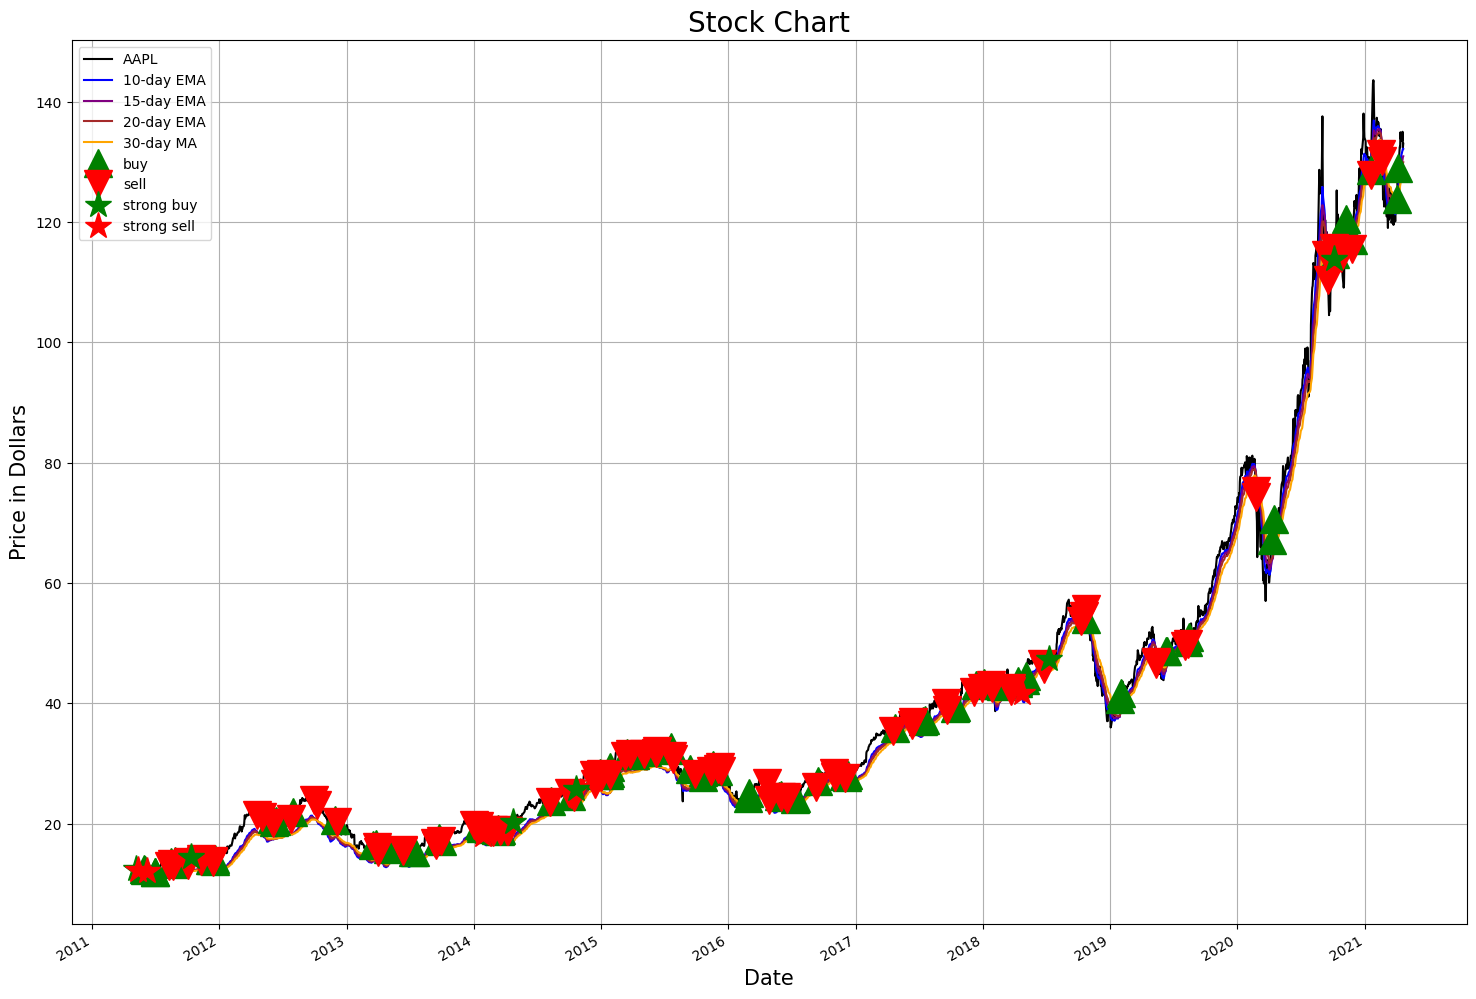

In [14]:
## Exponential Weighted Moving Average Cross-Over Strategy

## Make the EMAs
stock_EMAs = pd.DataFrame()

stock_EMAs['EMA10'] = stock_close['Close Price'].ewm(span=10).mean()
stock_EMAs['EMA15'] = stock_close['Close Price'].ewm(span=15).mean()
stock_EMAs['EMA20'] = stock_close['Close Price'].ewm(span=20).mean()
stock_EMAs['EMA30'] = stock_close['Close Price'].ewm(span=30).mean()

## 10-EMA crossing the slower 15-EMA
stock_df['15EMA_Signal'] = 0.0
stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

## 10-EMA crossing the slower 20-EMA
stock_df['20EMA_Signal'] = 0.0
stock_df['20MA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA20'], 1.0, 0.0)

## 10-EMA crossing the slower 30-EMA
stock_df['30EMA_Signal'] = 0.0
stock_df['30EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA30'], 1.0, 0.0)


## When ‘XMA_Signal_Change’ = 1, it implies that the XMA_Cross Signal has changed from 0 to 1
## meaning a short-term(faster) moving average has crossed above the
## long-term(slower) moving average, thereby triggering a buy call.
## 
## When ‘XMA_Signal_Change’ = -1, it implies that the XMA_Cross Signal has changed from 1 to 0
## meaning a short-term(faster) moving average has crossed below the
## long-term(slower) moving average, thereby triggering a sell call.
EMA15_signal = stock_df['15EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA15_signal

EMA20_signal = stock_df['20EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA20_signal

EMA30_signal = stock_df['30EMA_Signal'].diff()
stock_df['15EMA_Signal_Change'] = EMA30_signal

## 1 means both the 5MA and 10MA have buy signals, whereas -1 means both the 5MA and 10MA have sell signals.
## 0 registers as conclicting opinion between the moving averages.
stock_df['EMA_Signal_Change'] = EMA15_signal + EMA20_signal + EMA30_signal



#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_EMAs['EMA10'].plot(color = 'b',label = '10-day EMA') 
stock_EMAs['EMA15'].plot(color = 'purple',label = '15-day EMA') 
stock_EMAs['EMA20'].plot(color = 'brown', label = '20-day EMA')
stock_EMAs['EMA30'].plot(color = 'orange', label = '30-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] >= 2].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] >= 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['EMA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['EMA_Signal_Change'] <= -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()



## Check Volatility by tallying the crosses done in a 5-day span.
## Each cross can generate +1 Volatility point, and each day subtracts 0.2 until it hits 0. 
## Or it can have a half-life of 2 or 3 days...

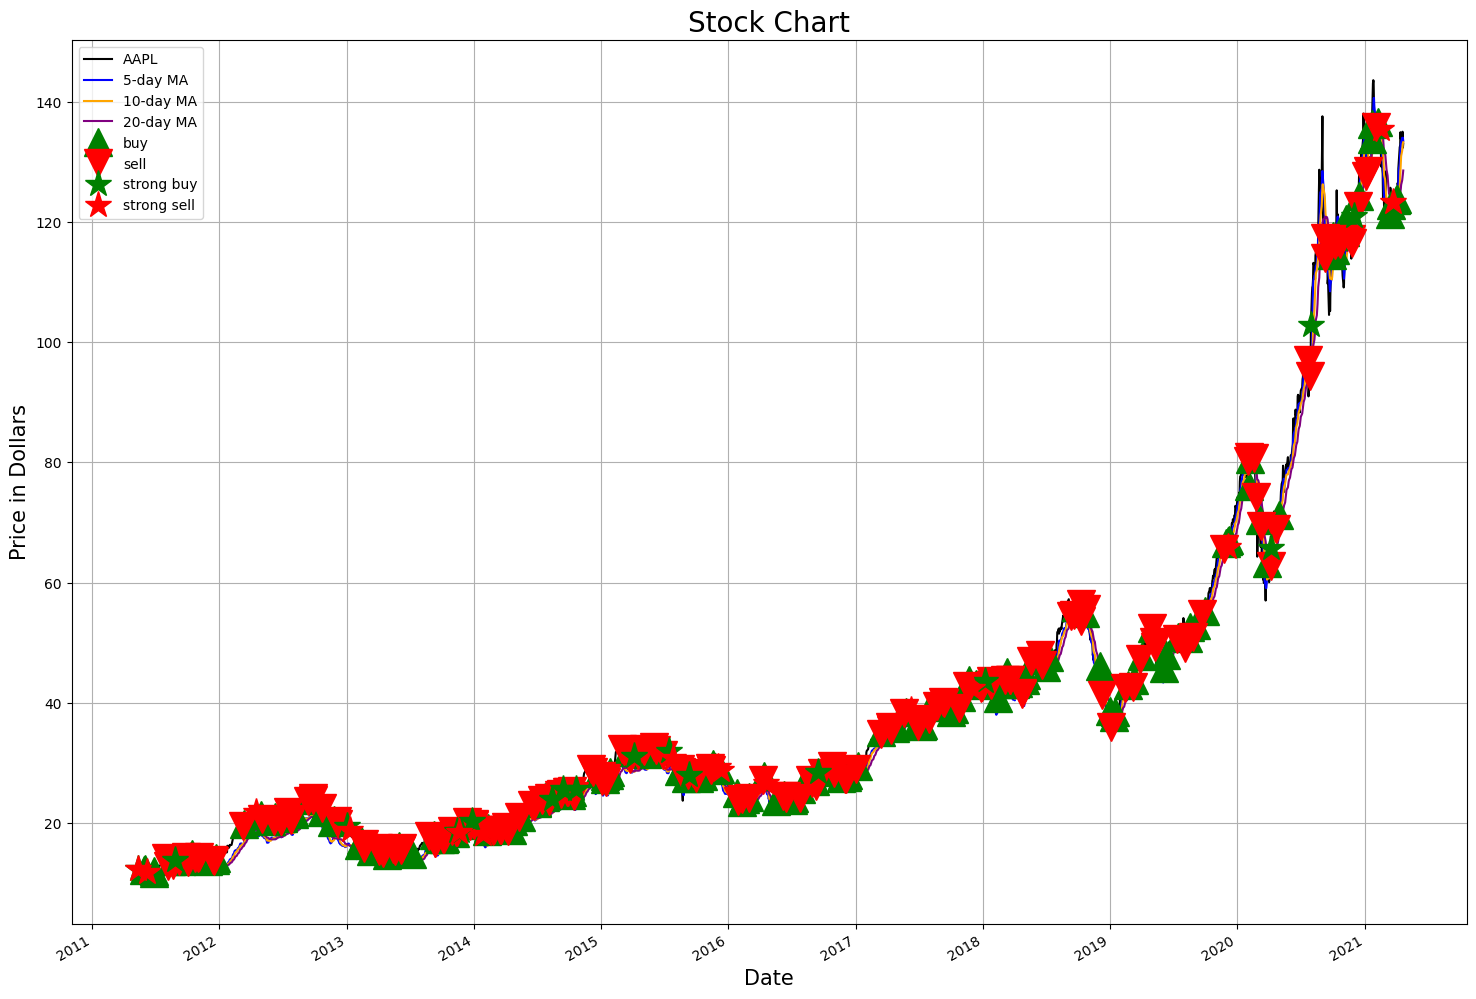

In [15]:
#plt.figure(figsize = (20,10))
plt.rcParams['figure.figsize'] = [18, 13]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# plot close price, short-term and long-term moving averages 
daily_df_original['Open'].plot(color = 'k', label= 'Open Price') 
stock_MAs['5MA'].plot(color = 'b',label = '5-day MA') 
stock_MAs['10MA'].plot(color = 'orange', label = '10-day MA')
stock_MAs['20MA'].plot(color = 'purple', label = '20-day MA')

# plot ‘buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 1], 
         '^', markersize = 20, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -1].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -1], 
         'v', markersize = 20, color = 'r', label = 'sell')

# plot ‘strong buy’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == 2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == 2], 
         '*', markersize = 20, color = 'g', label = 'strong buy')
# plot ‘strong sell’ signals
plt.plot(daily_df_original[stock_df['MA_Signal_Change'] == -2].index, 
         daily_df_original['Open'][stock_df['MA_Signal_Change'] == -2], 
         '*', markersize = 20, color = 'r', label = 'strong sell')

plt.ylabel('Price in Dollars', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stock Chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [16]:
monthly_df = pd.DataFrame(data=None, columns=None, index=daily_df_original.index)

monthly_df.insert(0,'High',monthly_df_original['High'])
monthly_df.insert(1,'Low',monthly_df_original['Low'])

## Fills the NaN missing values with the last valid value.
## This allows the lowest and highest values of the month populate each day, so to allow comparison to the daily dataframe.
monthly_df = monthly_df.fillna(method='bfill') 
#monthly_df.insert(2,'Close',stock_close['Close Price'])

monthly_highest = monthly_df['High']
monthly_lowest = monthly_df['Low']
monthly_average = (monthly_lowest + monthly_highest)/2
monthly_25th_high_percentile = (monthly_average+monthly_highest)/2
monthly_df['25% Highest'] = monthly_average #monthly_25th_high_percentile
monthly_25th_low_percentile = (monthly_average+monthly_lowest)/2

monthly_13th_low_percentile = (monthly_25th_low_percentile+monthly_lowest)/2
monthly_6th_low_percentile = (monthly_13th_low_percentile+monthly_lowest)/2
monthly_3rd_low_percentile = (monthly_6th_low_percentile+monthly_lowest)/2

monthly_df['25% Lowest'] = monthly_3rd_low_percentile #monthly_25th_low_percentile

#stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

#if bollinger_df.iloc[0][symbol] <= bollinger_df.iloc[0]['Lower Bollinger Band']:


#stock_df['15EMA_Signal'] = np.where(stock_EMAs['EMA10'] > stock_EMAs['EMA15'], 1.0, 0.0)

Buy_Sell_Labels = []
for price_index in range(len(monthly_df)):
    if (stock_close.iloc[price_index]['Close Price'] >= monthly_df.iloc[price_index]['25% Highest']): # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
        Buy_Sell_Labels.append(-1.0)        

    elif (stock_close.iloc[price_index]['Close Price'] <= monthly_df.iloc[price_index]['25% Lowest']): #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
        Buy_Sell_Labels.append(1.0)

    else:
        Buy_Sell_Labels.append(0.0)
        
        
stock_df['Buy_Sell_Labels'] = Buy_Sell_Labels     
stock_df = stock_df.fillna(0)

# for price_index in range(len(monthly_df)):
#     if (stock_close.iloc[price_index]['Close Price'] >= monthly_df.iloc[price_index]['25% Highest']): # & (monthly_df.iloc[0]['Close'] >= monthly_25th_high_percentile):
#         stock_df.loc['Buy_Sell_Labels'] = 1
#         #stock_df = monthly_df.fillna(method='ffill') 


#     elif (stock_close.iloc[price_index]['Close Price'] <= monthly_df.iloc[price_index]['25% Lowest']): #& (monthly_df.iloc[price_index]['Close'] <= monthly_25th_low_percentile):
#         stock_df.loc['Buy_Sell_Labels'] = -1

#     else:
#         stock_df.loc['Buy_Sell_Labels'] = 0
    

In [17]:
monthly_df.head(10)

,High,Low,25% Highest,25% Lowest
Date,,,,
2011-05-05,12.576071,11.089286,11.832678,11.135748
2011-05-06,12.576071,11.089286,11.832678,11.135748
2011-05-09,12.576071,11.089286,11.832678,11.135748
2011-05-10,12.576071,11.089286,11.832678,11.135748
2011-05-11,12.576071,11.089286,11.832678,11.135748
2011-05-12,12.576071,11.089286,11.832678,11.135748
2011-05-13,12.576071,11.089286,11.832678,11.135748
2011-05-16,12.576071,11.089286,11.832678,11.135748
2011-05-17,12.576071,11.089286,11.832678,11.135748


In [18]:
stock_close.iloc[100]['Close Price']
#stock_close.tail(10)

12.282424926757812

In [19]:
monthly_df.iloc[100]['25% Highest']

13.773571491241455

In [20]:
#stock_close.iloc[100]['Close Price'] >= monthly_df.iloc[100]['25% Highest']
stock_close.iloc[100]['Close Price'] <= monthly_df.iloc[100]['25% Lowest']

True

In [21]:
stock_df[100:101]

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change,15EMA_Signal,20EMA_Signal,30EMA_Signal,15EMA_Signal_Change,EMA_Signal_Change,Buy_Sell_Labels
Date,,,,,,,,,,,,,,,,,,,,,
2011-09-27,1.0,1.0,0.0,0.0,0.0,1.783938,0.227139,2.18358,0.328734,1.82347,...,-2.382891,0.004431,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [22]:
len(monthly_df)

2508

In [23]:
range(len(monthly_df))

range(0, 2508)

In [24]:
stock_df[:]

,10MA_Signal,20MA_Signal,10MA_Signal_Change,20MA_Signal_Change,MA_Signal_Change,Distance_of_Low_to_5MA,ROC_of_Low_to_5MA,Distance_of_High_to_5MA,ROC_of_High_to_5MA,Distance_of_Low_to_10MA,...,Distance_of_EMA9_to_MACD,ROC_of_EMA9_to_MACD,MACD_Signal,MACD_Signal_Change,15EMA_Signal,20EMA_Signal,30EMA_Signal,15EMA_Signal_Change,EMA_Signal_Change,Buy_Sell_Labels
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-05,0.0,0.0,0.0,0.0,0.0,1.691864,0.000000,1.866864,0.000000,1.691864,...,-2.595429,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-05-06,0.0,0.0,0.0,0.0,0.0,1.698964,0.007100,1.834321,0.007100,1.698964,...,-2.595463,-0.000035,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-05-09,0.0,1.0,0.0,0.0,0.0,1.701213,0.002250,1.796571,0.002250,1.701213,...,-2.595114,0.000349,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0
2011-05-10,0.0,1.0,0.0,0.0,0.0,1.687041,-0.014173,1.795255,-0.014173,1.687041,...,-2.594119,0.000995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2011-05-11,0.0,1.0,0.0,0.0,0.0,1.638695,-0.048346,1.808695,-0.048346,1.638695,...,-2.593976,0.000143,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16,1.0,1.0,0.0,0.0,0.0,0.007999,-1.041501,1.397998,-0.592001,2.306998,...,-1.246742,0.311686,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2021-04-19,1.0,1.0,0.0,0.0,0.0,-0.652002,-0.682502,1.478003,-0.660001,1.472997,...,-0.962521,0.284221,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2021-04-20,1.0,1.0,0.0,0.0,0.0,-1.918002,-2.015999,1.801999,-1.266000,-0.747002,...,-0.741737,0.220785,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [25]:
stock_df.info() ## Check for any categorical feature

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2508 entries, 2011-05-05 to 2021-04-22
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   10MA_Signal                       2508 non-null   float64
 1   20MA_Signal                       2508 non-null   float64
 2   10MA_Signal_Change                2508 non-null   float64
 3   20MA_Signal_Change                2508 non-null   float64
 4   MA_Signal_Change                  2508 non-null   float64
 5   Distance_of_Low_to_5MA            2508 non-null   float64
 6   ROC_of_Low_to_5MA                 2508 non-null   float64
 7   Distance_of_High_to_5MA           2508 non-null   float64
 8   ROC_of_High_to_5MA                2508 non-null   float64
 9   Distance_of_Low_to_10MA           2508 non-null   float64
 10  Distance_of_High_to_10MA          2508 non-null   float64
 11  ROC_of_High_to_10MA               2508 non-null   f

In [26]:
print(stock_df.isnull().sum())


10MA_Signal                         0
20MA_Signal                         0
10MA_Signal_Change                  0
20MA_Signal_Change                  0
MA_Signal_Change                    0
Distance_of_Low_to_5MA              0
ROC_of_Low_to_5MA                   0
Distance_of_High_to_5MA             0
ROC_of_High_to_5MA                  0
Distance_of_Low_to_10MA             0
Distance_of_High_to_10MA            0
ROC_of_High_to_10MA                 0
Distance_of_Low_to_20MA             0
Distance_of_High_to_20MA            0
High_BOLL_Signal                    0
Low_BOLL_Signal                     0
Distance_of_High_to_High_BOLL       0
ROC_of_High_to_High_BOLL            0
Distance_of_Close_to_High_BOLL      0
ROC_of_Close_to_High_BOLL           0
Distance_of_Low_to_Low_BOLL         0
ROC_of_Low_to_Low_BOLL              0
Distance_of_Close_to_Low_BOLL       0
ROC_of_Close_to_Low_BOLL            0
Distance_of_Close_to_Future_MACD    0
ROC_of_Close_to_Future_MACD         0
Distance_of_

In [27]:
## X ... axis=1 is for choosing to drop/remove the column values from the data frame matrix
X = stock_df.drop('Buy_Sell_Labels', axis=1).values
### X is the target values

## y ... this takes those values dropped and assigns it to the GROUND TRUTH "y" label 
y_ = stock_df['Buy_Sell_Labels'].values

## Labels are already normalized, so this is a redundant step.
y = y_ / np.max(y_)
### y is the target labels

print(y)
print(y==y_)
print(y.shape)
y[100:150]

[1. 1. 1. ... 0. 0. 0.]
[ True  True  True ...  True  True  True]
(2508,)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=508,
                                                            random_state=0)


print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

train_val: 2000, test: 508


In [29]:
# here we use 10-fold cross-validation
folds = 10

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [10**-5,10**-4,10**-3,10**-2,10**-1,1.0,10,20,50,100]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        ## 'l2'-regularizer , C = regularization coefficient
        ## 'lbfgs' is for L2
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs',max_iter=10000)
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
        
        coefficient_list = clf.coef_
    
    cur_acc = sum_acc / folds
    
    print("reg: {}, reg_coeff: {}, acc: {:.3f}".format(reg, 1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
print("best_reg: {}".format(best_reg))

[[1326  555 1501 ...  711 1396  365]
 [ 996 1314  825 ...  610  372  814]
 [1123 1558 1902 ... 1191  347 1020]
 ...
 [ 118  124  468 ... 1772  977  270]
 [1502 1016 1352 ... 1781 1469  131]
 [ 858 1974 1302 ...  178  548  107]]
reg: 1e-05, reg_coeff: 99999.99999999999, acc: 0.690
reg: 0.0001, reg_coeff: 10000.0, acc: 0.690
reg: 0.001, reg_coeff: 1000.0, acc: 0.703
reg: 0.01, reg_coeff: 100.0, acc: 0.692
reg: 0.1, reg_coeff: 10.0, acc: 0.694
reg: 1.0, reg_coeff: 1.0, acc: 0.693
reg: 10, reg_coeff: 0.1, acc: 0.692
reg: 20, reg_coeff: 0.05, acc: 0.692
reg: 50, reg_coeff: 0.02, acc: 0.692
reg: 100, reg_coeff: 0.01, acc: 0.692
best_reg: 0.001


In [30]:
## your code

clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs',max_iter=10000)
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)

print(classification_report(y_test, y_test_pred))

# acc = accuracy_score(y_test, y_test_pred)
# f1 = f1_score(y_test, y_test_pred)
# recall = recall_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred)

# ## This perfect performance is realalistically impossible
# print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

              precision    recall  f1-score   support

        -1.0       0.44      0.07      0.12        58
         0.0       0.60      0.07      0.12        88
         1.0       0.74      1.00      0.85       362

    accuracy                           0.73       508
   macro avg       0.59      0.38      0.36       508
weighted avg       0.68      0.73      0.64       508



In [31]:
round(clf.score(X,y), 5)

0.70694

In [32]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2869094488188976
Mean Squared Error: 0.18750492125984253
Root Mean Squared Error: 0.4330183844363222
